<a href="https://colab.research.google.com/github/pminchara/ML_Assignment/blob/main/Final_ML_Assignment_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Assignment**

# **Importing all the necessary libraries**

In [ ]:
# %tensorflow_version 2.x

# import tensorflow and tensorflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# import ImageDataGenerator and the related functions required for processing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# import optimizers
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop

# import statements for building and loading the model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json

# import statements for callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# import statements for initlializers and regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

# import statements for one-hot encoding, model plotting
from tensorflow.keras.utils import to_categorical, plot_model

# import statements for loading ResNet50 from keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# import statements for scikit-learn
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# import scipy
import scipy.misc

# import os for file access
import os 

# import glob
import glob

# import numpy, pandas
import numpy as np
import pandas as pd

# import opencv
import cv2

# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# import zipfile for unzipping the data
import zipfile

# import csv to access the csv files
import csv

# import drive to access the data from GDrive
from google.colab import drive

# import seaborn
import seaborn as sns

# import time
from time import time

# **Mount Google Drive to load the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ML/ML Group project/Dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Specifying the directories

In [ ]:
training_dir = '/tmp/Dataset/train/'
testing_dir = '/tmp/Dataset/test'
validation_dir = '/tmp/Dataset/validation/'

In [ ]:
train_images = sum(len(files) for _,_, files in os.walk(training_dir))
test_images = sum(len(files) for _,_, files in os.walk(testing_dir))
validation_images = sum(len(files) for _,_, files in os.walk(validation_dir))

In [ ]:
print("Number of training images =",train_images)
print("Number of testing images =",test_images)
print("Number of validation images =",validation_images)

Number of training images = 1000
Number of testing images = 79
Number of validation images = 160


# **Using ImageDataGenerator to feed the data into the network**

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   width_shift_range= 0.1,
                                   height_shift_range= 0.1,
                                   zoom_range= 0.2,
                                   horizontal_flip= True,
                                   fill_mode= "nearest")
test_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()
train_data = train_datagen.flow_from_directory(training_dir, class_mode='categorical', target_size=(224,224), batch_size=16)
test_data = test_datagen.flow_from_directory(testing_dir, class_mode='categorical', target_size=(224,224), batch_size=16,shuffle=False)
valid_data = valid_datagen.flow_from_directory(validation_dir, class_mode='categorical', target_size=(224,224), batch_size=16,shuffle=False)

Found 1000 images belonging to 2 classes.
Found 79 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


# **Loading the pre-trained ResNet50 model**

Specifying the weights and input_shape. The "include_top = False" indicates that the pre-trained model is used on another classification challenge instead of ImageNet. In this case, we want to classify images of four different categories.

In [ ]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

Displaying the pre-trained ResNet50 model's architecture

In [ ]:
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# **Adding Fully Connected Layer on the top of pre-trained ResNet50 base layer**

In [ ]:
model = models.Sequential()
model.add(resnet_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 49,278,594
Trainable params: 49,225,474
Non-trainable params: 53,120
_________________________________________________________________


# **Freezing the pre-trained ResNet50 base**

In [ ]:
for layer in resnet_base.layers[:]:
  layer.trainable = False

Display the architecture of the full CNN model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 49,278,594
Trainable params: 25,690,882
Non-trainable params: 23,587,712
_________________________________________________________________


Specifying the learning rate

In [ ]:
learning_rate = 1e-4

Compile the CNN model

In [ ]:
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

Specifying the callbacks

In [ ]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath = 'resnet-cnn-model.h5',
        monitor = 'val_loss',
        save_best_only = True)]

# **Training the fully connected layer only (ResNet50 base is frozen)**

In [ ]:
batch_size = 16
history = model.fit(train_data,
                             steps_per_epoch=train_images//batch_size,
                             epochs=3,
                             validation_data=valid_data,
                             validation_steps=validation_images//batch_size,
                             callbacks=callbacks_list)

Epoch 1/3
62/62 [==============================] - 23s 295ms/step - loss: 1.4385 - accuracy: 0.5847 - val_loss: 0.4870 - val_accuracy: 0.8125
Epoch 2/3
62/62 [==============================] - 17s 280ms/step - loss: 0.6774 - accuracy: 0.7900 - val_loss: 0.4305 - val_accuracy: 0.8625
Epoch 3/3
62/62 [==============================] - 18s 283ms/step - loss: 0.6667 - accuracy: 0.7919 - val_loss: 0.3574 - val_accuracy: 0.8500


# **Unfreezing the ResNet 5c block**

In [ ]:
resnet_base.trainable = True
set_trainable = False
for layer in resnet_base.layers:
  if 'conv5_block3' in layer.name:
    set_trainable= True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable= False

In [ ]:
for i, layer in enumerate(resnet_base.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 49,278,594
Trainable params: 30,156,546
Non-trainable params: 19,122,048
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 16
history = model.fit(train_data,
                             steps_per_epoch=train_images//batch_size,
                             epochs=30,
                             validation_data=valid_data,
                             validation_steps=validation_images//batch_size,
                             callbacks=callbacks_list)

Epoch 1/30
62/62 [==============================] - 21s 294ms/step - loss: 0.5556 - accuracy: 0.8216 - val_loss: 0.3647 - val_accuracy: 0.8687
Epoch 2/30
62/62 [==============================] - 17s 280ms/step - loss: 0.4739 - accuracy: 0.8431 - val_loss: 0.2955 - val_accuracy: 0.8875
Epoch 3/30
62/62 [==============================] - 17s 282ms/step - loss: 0.3971 - accuracy: 0.8479 - val_loss: 0.2829 - val_accuracy: 0.8938
Epoch 4/30
62/62 [==============================] - 17s 282ms/step - loss: 0.4802 - accuracy: 0.8413 - val_loss: 0.3263 - val_accuracy: 0.8875
Epoch 5/30
62/62 [==============================] - 17s 279ms/step - loss: 0.4398 - accuracy: 0.8341 - val_loss: 0.2573 - val_accuracy: 0.8813
Epoch 6/30
62/62 [==============================] - 18s 283ms/step - loss: 0.4073 - accuracy: 0.8465 - val_loss: 0.2508 - val_accuracy: 0.9000
Epoch 7/30
62/62 [==============================] - 17s 280ms/step - loss: 0.3242 - accuracy: 0.8796 - val_loss: 0.2497 - val_accuracy: 0.9000

In [ ]:
model = load_model("/content/resnet-cnn-model.h5")

# **Plot the learning curves for Accuracy and Loss**

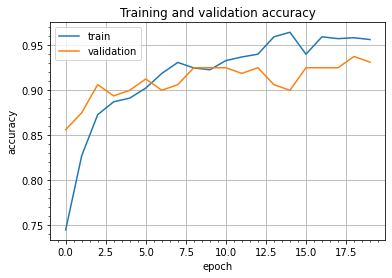

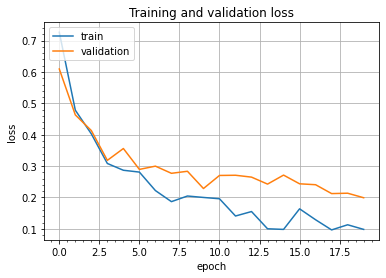

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.minorticks_on()
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('RESNET Final Model Accuracy', dpi=250)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.minorticks_on()
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('RESNET Final Model Loss', dpi=250)
plt.show()

# **Evaluate the model**

In [ ]:
validation_datagen = ImageDataGenerator()
evaluate_datagen = validation_datagen.flow_from_directory(validation_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 160 images belonging to 2 classes.


In [ ]:
print('Validate the model')
final_result = model.evaluate(
    evaluate_datagen,
    steps = validation_images)

Validate the model
160/160 [==============================] - 10s 13ms/step - loss: 0.1547 - accuracy: 0.9438


In [ ]:
t0 = time()
evaluate_datagen.reset()
val_predict = model.predict(
    evaluate_datagen,
    steps = validation_images,
    verbose = 1)
print('Time taken to evaluate the model:',int(time()-t0),'seconds')

160/160 [==============================] - 3s 12ms/step
Time taken to evaluate the model: 2 seconds


# **Produce a classification report for Validation set**

In [ ]:
validation_samples = val_predict.shape[0]
print('Number of data points in validation set:',validation_samples)

Number of data points in validation set: 160


In [ ]:
val_predicted_classes = np.argmax(val_predict, axis = 1)
val_true_classes = evaluate_datagen.classes
val_class_labels = list(evaluate_datagen.class_indices.keys())

Performance metrics for Validation set

In [ ]:
validation_report = metrics.classification_report(val_true_classes, val_predicted_classes, target_names=val_class_labels)
print('The validation report is as follows:')
print(validation_report)

The validation report is as follows:
              precision    recall  f1-score   support

    Accident       0.95      0.93      0.94        75
 No Accident       0.94      0.95      0.95        85

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



Confusion matrix with the numbers of true and predicted labels for each class in Validation set

In [ ]:
val_conf_matrix = tf.math.confusion_matrix(labels=val_true_classes, predictions=val_predicted_classes).numpy()
print(val_conf_matrix)

[[70  5]
 [ 4 81]]


Visualization of Confusion Matrix for Validation set

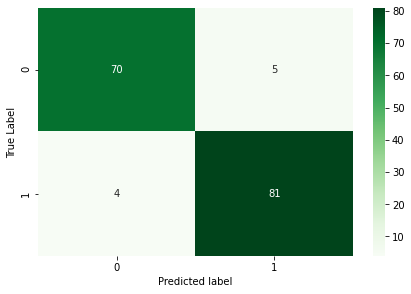

In [ ]:
figure1 = plt.figure()
sns.heatmap(val_conf_matrix, annot = True, cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Validation data Confusion Matrix', dpi=250)
plt.show()

# **Test the model**

In [ ]:
testing_datagen = ImageDataGenerator()
test_data_datagen = testing_datagen.flow_from_directory(testing_dir, class_mode='categorical', target_size=(224,224), batch_size=1,shuffle=False)

Found 79 images belonging to 2 classes.


In [ ]:
print('Testing the model')
final_result = model.evaluate(
    test_data_datagen,
    steps = test_images)

Testing the model
79/79 [==============================] - 1s 18ms/step - loss: 0.4089 - accuracy: 0.8987


In [ ]:
test_data_datagen.reset()
predict_on_test_data = model.predict(
    test_data_datagen,
    steps = test_images,
    verbose = 1
)

79/79 [==============================] - 1s 16ms/step


In [ ]:
print('Number of data points in test set:',predict_on_test_data.shape[0])

Number of data points in test set: 79


# **Produce a classification report for Test set**

In [ ]:
predicted_classes = np.argmax(predict_on_test_data,axis=1)
predict_true_classes = test_data_datagen.classes
predict_class_labels = list(test_data_datagen.class_indices.keys())

Performance metrics for Test set

In [ ]:
test_report = metrics.classification_report(predict_true_classes, predicted_classes, target_names = predict_class_labels)
print(test_report)

              precision    recall  f1-score   support

    Accident       0.87      0.87      0.87        30
 No Accident       0.92      0.92      0.92        49

    accuracy                           0.90        79
   macro avg       0.89      0.89      0.89        79
weighted avg       0.90      0.90      0.90        79



Confusion matrix with the numbers of true and predicted labels for each class in Test set

In [ ]:
test_confusion_matrix = tf.math.confusion_matrix(labels=predict_true_classes,predictions = predicted_classes).numpy()
print(test_confusion_matrix)

[[26  4]
 [ 4 45]]


Visualization of Confusion Matrix for Test set

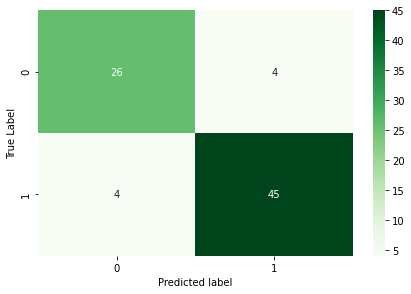

In [ ]:
figure1 = plt.figure()
sns.heatmap(test_confusion_matrix, annot = True, cmap=plt.cm.Greens)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted label')
plt.savefig('Test data Confusion Matrix', dpi=250)
plt.show()

## **Predicting the images in-wild**

In [44]:
IMG_CATEGORIES = {0: 'Accident', 1: 'No Accident'}

In [51]:
def pred_img(img_path):
  IMG_SIZE = 224
  img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), interpolation='nearest')
  prediction = model.predict(np.expand_dims(img, axis=0))
  result = np.argmax(prediction, axis=1)
  result = IMG_CATEGORIES.get(int(result))
  display_img = img_to_array(img)
  plt.imshow(display_img/255.)
  print("Model's prediction:", result)

Model's prediction: Accident


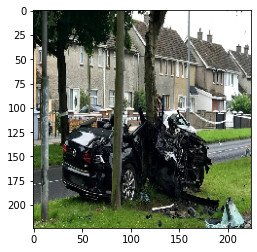

In [58]:
pred_img('/content/drive/MyDrive/ML/ML Group project/In-wild/72b08c33-9ed2-4bec-8f90-06c964739842__93413b71-22e4-4c36-bda5-14c7b9f57773.jpg')

Model's prediction: No Accident


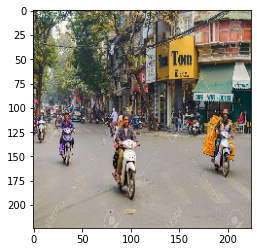

In [59]:
pred_img('/content/drive/MyDrive/ML/ML Group project/In-wild/95785232-hanoi-vietnam-december-05-2016-car-and-motorbike-traffic-in-the-old-quarter-in-hanoi-.jpg')

Model's prediction: Accident


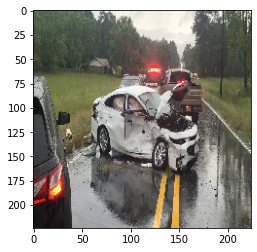

In [60]:
pred_img('/content/drive/MyDrive/ML/ML Group project/In-wild/Car-Accident-1.jpg')

Model's prediction: Accident


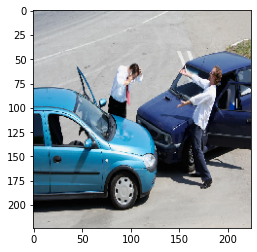

In [61]:
pred_img('/content/drive/MyDrive/ML/ML Group project/In-wild/Car-Accident.jpeg')

Model's prediction: No Accident


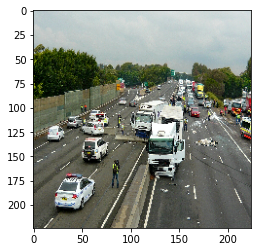

In [62]:
pred_img('/content/drive/MyDrive/ML/ML Group project/In-wild/Multi_vehicle_accident_-_M4_Motorway,_Sydney,_NSW_(8076208846).jpg')

Model's prediction: Accident


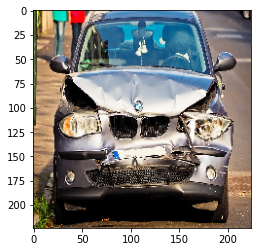

In [63]:
pred_img('/content/drive/MyDrive/ML/ML Group project/In-wild/auto-3734396_960_720.jpg')

Model's prediction: No Accident


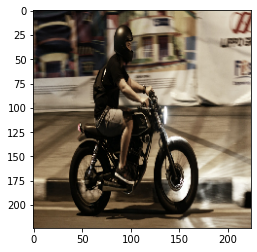

In [64]:
pred_img('/content/drive/MyDrive/ML/ML Group project/In-wild/motorbike-traffic-collision-common-causes-and-how-to-avoid-them.jpg')